In [1]:
# Installation des dépendances
# -----------------------------
! sudo apt-get update
! sudo mkdir -p /usr/share/man/man1
! sudo apt-get install -y openjdk-11-jdk
! pip install pyspark
! pip install openpyxl
! pip install mysql-connector-python

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian-security buster/updates InRelease
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Fetched 56.6 kB in 0s (280 kB/s)




openjdk-11-jdk is already the newest version (11.0.16+8-1~deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [27]:
# Imports
# ---------------------------
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import pyspark.sql.functions as F 
import mysql.connector
from pyspark.sql.types import *
import plotly.express as px


# Localisation des fichiers
#------------------------------------
file_location = "/work/data-csv/"

# Initialisation de la base de données MySQL

In [4]:


df_1 = _deepnote_execute_sql("""-- Création table airlines
CREATE TABLE IF NOT EXISTS airlines (
id INT PRIMARY KEY AUTO_INCREMENT,
carrier VARCHAR(3) NOT NULL,
name VARCHAR(255) NOT NULL,
UNIQUE (carrier)
);
""", 'SQL_662EF500_BE86_46B9_AAF1_A5C4035D5EF7')
df_1

In [5]:


df_3 = _deepnote_execute_sql("""-- Création table planes
CREATE TABLE IF NOT EXISTS planes (
id INT PRIMARY KEY AUTO_INCREMENT,
tailnum VARCHAR(10),
year INT,
type_plane VARCHAR(255) NOT NULL,
manufacturer VARCHAR(255) NOT NULL,
model VARCHAR(255) NOT NULL,
engine_name VARCHAR(255) NOT NULL,
engine_nb INT NOT NULL,
seats INT NOT NULL,
speed VARCHAR(255),
UNIQUE (tailnum)
);
""", 'SQL_662EF500_BE86_46B9_AAF1_A5C4035D5EF7')
df_3

In [6]:


df_4 = _deepnote_execute_sql("""-- Création table airports
CREATE TABLE IF NOT EXISTS airports (
id INT PRIMARY KEY AUTO_INCREMENT,
faa VARCHAR(10),
name VARCHAR(255) NOT NULL,
lat FLOAT NOT NULL,
lon FLOAT NOT NULL,
alt INT NOT NULL,
tz INT NOT NULL,
dst VARCHAR(10),
tzone VARCHAR(100),
UNIQUE (faa)
);
""", 'SQL_662EF500_BE86_46B9_AAF1_A5C4035D5EF7')
df_4

In [7]:


df_6 = _deepnote_execute_sql("""-- Création table weather
CREATE TABLE IF NOT EXISTS weather (
id INT PRIMARY KEY AUTO_INCREMENT,
origin VARCHAR(10) NOT NULL,
year INT,
month INT,
day INT,
hour INT,
temp FLOAT,
dewp FLOAT,
humid FLOAT,
wind_dir INT,
wind_speed FLOAT,
wind_gust FLOAT,
precip FLOAT,
pressure FLOAT,
visib FLOAT,
time_hour VARCHAR(255)
);
""", 'SQL_662EF500_BE86_46B9_AAF1_A5C4035D5EF7')
df_6

In [8]:


df_5 = _deepnote_execute_sql("""-- Création table flights
-- carrier = airlines.carrier => airline_id
-- flight = planes.tailnum => plane_id
-- origin = airports.faa => origin_id
-- dest = airports.faa => dest_id
CREATE TABLE IF NOT EXISTS flights (
id INT PRIMARY KEY AUTO_INCREMENT,
year INT NOT NULL,
month INT NOT NULL,
day INT NOT NULL,
dep_time INT,
sched_dep_time INT,
dep_delay INT,
arr_time INT,
sched_arr_time INT,
arr_delay INT,
carrier VARCHAR(10) NOT NULL,
flight INT,
tailnum VARCHAR(10) NOT NULL,
origin VARCHAR(10) NOT NULL, 
dest VARCHAR(10) NOT NULL,
air_time INT,
distance INT,
hour INT NOT NULL,
minute INT NOT NULL,
time_hour VARCHAR(255) NOT NULL
);
""", 'SQL_662EF500_BE86_46B9_AAF1_A5C4035D5EF7')
df_5

In [9]:
# Vérification des tables
mycursor = db_airlines.cursor()
mycursor.execute("SHOW TABLES")

# Lister des tables existant dans la base de donnee
for x in mycursor:
  print(x)

('airlines',)
('airports',)
('auth_group',)
('auth_group_permissions',)
('auth_permission',)
('auth_user',)
('auth_user_groups',)
('auth_user_user_permissions',)
('django_admin_log',)
('django_content_type',)
('django_migrations',)
('django_session',)
('flights',)
('planes',)
('weather',)


In [10]:
# Création des dataframes des fichiers excel
# airlines = pd.read_excel(file_location + "airlines.xlsx")
# airports = pd.read_excel(file_location + "airports.xlsx")
# flights = pd.read_excel(file_location + "flights.xlsx")

# Création des dataframes à partir des fichiers csv
airlines = spark.read.csv(file_location + "airlines.csv" , header=True, inferSchema=True)
planes = spark.read.csv(file_location + "planes.csv", header=True, inferSchema=True)
weather = spark.read.csv(file_location + "weather.csv", header=True, inferSchema=True)
airports = spark.read.csv(file_location + "airports.csv" , header=True, inferSchema=True)
flights = spark.read.csv(file_location + "flights.csv" , header=True, inferSchema=True)


Problème rencontré ici pour la sauvegarde des données dans la base de données MySQL depuis DeepNote. 

Nous avons donc utilisés Databricks pour faire le traitement et l'enregistrement des données.

In [3]:
# Essai d'utiliser mysql.connector.python pour palier au problème d'envoi depuis DeepNote. 
# Abordé suite à l'utilisation de Databricks

# Connexion a alwaysdata
db_airlines = mysql.connector.connect(
    host="xxx.alwaysdata.net",
    user="xxx",
    password="xxx",
    database="db_airlines"
)
# Vérifier la connexion 
print(db_airlines)

# Mission 1 : Se familiariser avec les données


undefined. Combien y-a-t-il :  
      - d’aéroports en tout, de départ et de destination 
      - Combien y-a-t-il d’aéroports où on ne passe pas à l’heure d’été ? de fuseaux horaires 
      - de compagnies, d’avions, de vols annulés ?  

In [103]:
# Nombre d'aéroports
allAirports = airports.select('name').count()
print("Il y a " + str(allAirports) + " d'aéroports.\n")

# Nombre d'aéroports de depart
allAirportDeparture = flights.groupBy('origin').agg({'origin': 'count'})\
                      .withColumnRenamed('origin', 'Aeroport')\
                      .withColumnRenamed('count(origin)', 'Nombre de vols')
print("Il y a " + str(allAirportDeparture.select('Aeroport').count()) + " aéroports de départs : ")
allAirportDeparture.show()

# Nombre d'aéroports de destination
allAirportArrival = flights.groupBy('dest').agg({'dest': 'count'})\
                    .withColumnRenamed('dest', 'Aeroport')\
                    .withColumnRenamed('count(dest)', 'Nombre de vols')
print("Il y a " + str(allAirportArrival.select('Aeroport').count()) + " aéroports de destinations : ")
allAirportArrival.show()

Il y a 1458 d'aéroports.

Il y a 3 aéroports de départs : 
+--------+--------------+
|Aeroport|Nombre de vols|
+--------+--------------+
|     LGA|         78344|
|     EWR|         91241|
|     JFK|         83119|
+--------+--------------+

Il y a 103 aéroports de destinations : 
+--------+--------------+
|Aeroport|Nombre de vols|
+--------+--------------+
|     PSE|           275|
|     MSY|          2831|
|     SNA|           600|
|     BUR|           281|
|     GRR|           589|
|     MYR|            58|
|     GSO|          1199|
|     PVD|           331|
|     OAK|           222|
|     MSN|           441|
|     DCA|          7386|
|     ORF|          1214|
|     CRW|           138|
|     SAV|           598|
|     CMH|          2609|
|     CAK|           622|
|     IAH|          5438|
|     HNL|           533|
|     CVG|          2953|
|     SJC|           239|
+--------+--------------+
only showing top 20 rows



In [12]:
# Combien y-a-t-il d’aéroports où on ne passe pas à l’heure d’été ? de fuseaux horaires 
# la valeur A correspond à la zone d'heure d'été
# la valeur N correspond à la zone où il n'y a pas d'heure d'été.
# la valeur U correspond à une zone inconnue
no_summer_time = airports.filter(airports.dst == "N").count()
no_timezone = airports.filter(airports.dst == "U").count()
print("Il y a " + str(no_summer_time) + " aéroports où il n'y a pas d'heures d'été ainsi que " + str(no_timezone) + " aéroports qui ne possèdent pas de fuseaux horaires.")
airports.groupBy('dst').count().show()

Il y a 23 aéroports où il n'y a pas d'heures d'été ainsi que 47 aéroports qui ne possèdent pas de fuseaux horaires.
+---+-----+
|dst|count|
+---+-----+
|  U|   47|
|  A| 1388|
|  N|   23|
+---+-----+



In [13]:
# Nombre de compagnies
allAirlines = airlines.select("*")
# allAirlines.show()
print("Il y a " + str(allAirlines.count()) + " compagnies aériennes.\n")

# Nombre d’avions
allPlanes = planes.select("*")
# allPlanes.show()
# allPlanes.count()
print("Il y a " + str(allPlanes.count()) + " avions.\n")

# Nombre de vols annulés
allFlights = flights.filter(flights.air_time == ' ')
#allFlights.show()
print("Il y a " + str(allFlights.count()) + " vols annulés sur les " + str(flights.count()) + " vols.")

Il y a 16 compagnies aériennes.

Il y a 3322 avions.

Il y a 7273 vols annulés sur les 252704 vols.


2. Quel est l’aéroport de départ le plus emprunté ? Quelles sont les 10 destinations les plus (moins) prisées (en indiquant le nom complet des destinations et non juste le code correspondant et le % corresp pour chaque destination) ? Quelle sont les 10 avions qui ont le plus (moins) décollé ?

In [158]:
# Aéroport de départ le plus emprunté
flight_join_airport = flights.join(airports, airports.faa ==  flights.origin,"inner")
flight_desc_departures = flight_join_airport.groupBy('origin').\
                         agg({'origin': 'count'}).\
                         orderBy(F.col('count(origin)').desc())
airport_most_departure = airports.filter(airports.faa == flight_desc_departures.first()[0])
print("L'aéroport le plus emprunté est "+ airport_most_departure.select('name').collect()[0].name + \
    " avec "+ str(flight_desc_departures.first()[1]) + " départs.\n")

# Les 10 destinations les plus ou moins prisées
flights_most10_departures = flight_join_airport.groupBy('dest').\
                        agg({'dest': 'count'}).\
                        orderBy(F.col('count(dest)').desc())
list_10_code = []
list_10_count = []
for val in flights_most10_departures.take(10) :
    list_10_code.append(val['dest'])
    list_10_count.append(val['count(dest)'])

airport_most10_dest = airports.filter((airports.faa).isin(list_10_code)).take(10)
list_10_dest2 = [(val['name']) for val in airport_most10_dest]
print('Les 10 destinations les plus prisées sont: ')
test = tuple(zip(list_10_dest2, list_10_count))
display(test)

# Les 10 avions qui ont le plus ou moins décollés
planes_most10_departures = flight_join_airport.groupBy('tailnum').\
                        agg({'tailnum': 'count'}).\
                        orderBy(F.col('count(tailnum)').desc())

print('Les 10 avions qui ont le plus décollé sont: ')
display(planes_most10_departures.take(10))
print('Les 10 avions qui ont le moins décollé sont: ')
display(planes_most10_departures.tail(10))

L'aéroport le plus emprunté est Newark Liberty Intl avec 91241 départs.

Les 10 destinations les plus prisées sont: 


(('Hartsfield Jackson Atlanta Intl', 12946),
 ('General Edward Lawrence Logan Intl', 12654),
 ('Charlotte Douglas Intl', 11895),
 ('Ronald Reagan Washington Natl', 11560),
 ('Fort Lauderdale Hollywood Intl', 10637),
 ('Los Angeles Intl', 10448),
 ('Orlando Intl', 9729),
 ('Miami Intl', 9443),
 ('Chicago Ohare Intl', 8938),
 ('San Francisco Intl', 7386))

Les 10 avions qui ont le plus décollé sont: 


[Row(tailnum=' ', count(tailnum)=1973),
 Row(tailnum='N725MQ', count(tailnum)=443),
 Row(tailnum='N723MQ', count(tailnum)=394),
 Row(tailnum='N713MQ', count(tailnum)=385),
 Row(tailnum='N722MQ', count(tailnum)=378),
 Row(tailnum='N711MQ', count(tailnum)=376),
 Row(tailnum='N258JB', count(tailnum)=332),
 Row(tailnum='N353JB', count(tailnum)=316),
 Row(tailnum='N542MQ', count(tailnum)=310),
 Row(tailnum='N351JB', count(tailnum)=310)]

Les 10 avions qui ont le moins décollé sont: 


[Row(tailnum='N534AS', count(tailnum)=1),
 Row(tailnum='N608SW', count(tailnum)=1),
 Row(tailnum='N838MH', count(tailnum)=1),
 Row(tailnum='N921DN', count(tailnum)=1),
 Row(tailnum='N826MH', count(tailnum)=1),
 Row(tailnum='N595NW', count(tailnum)=1),
 Row(tailnum='N787UA', count(tailnum)=1),
 Row(tailnum='N837MH', count(tailnum)=1),
 Row(tailnum='N913EV', count(tailnum)=1),
 Row(tailnum='N587NW', count(tailnum)=1)]

3. Combien chaque compagnie a desservi de destination ; combien chaque compagnie a desservie de destination par aéroport d’origine. Réaliser les graphiques adéquats qui synthétisent ces informations ? 

In [101]:
#relecture avec pandas pour creation de plot
flights2 = pd.read_csv(file_location + "flights.csv")
planes2 = pd.read_csv(file_location + "planes.csv")
airports2 = pd.read_csv(file_location + "airports.csv")
weathers2 = pd.read_csv(file_location + "weather.csv")


# On unifie les donnees pour avoir des donnees coherentes
CompPerDest  = pd.merge(left = flights2, right = planes2, how = 'inner', on = 'tailnum' )
GroupCompPerDest = CompPerDest.groupby(['manufacturer', 'dest']).size().reset_index(name='counts')
GroupCompPerDest.loc[GroupCompPerDest['manufacturer'].str.contains('AIRBUS', case=False), 'manufacturer'] = 'AIRBUS'
GroupCompPerDest.loc[GroupCompPerDest['manufacturer'].str.contains('MCDONNELL', case=False), 'manufacturer'] = 'MCDONNELL'
GroupCompPerDest.loc[GroupCompPerDest['manufacturer'].str.contains('CANADAIR', case=False), 'manufacturer'] = 'CANADAIR'


Ci-dessous un graphique qui nous permet de voir quelle sont les destionations qui sont les plus prisées par les compagnies aérienne. On peut voir que notamment les grandes compagnie comme Boeing pratique de nombreux vols lorsqu'elle possede une destination, exemple LAX qui compte 7910 vols. Pour finir, on peut voir que la compagnie EMBREAER est sur toute les destination a l'exception de quelques unes.

In [95]:
graphCarrier = px.bar(GroupCompPerDest, x='dest', y='counts',color='manufacturer',
            labels={"counts": "Nombre de transporteur", "carrier": "Transporter"})
graphCarrier.show()

In [16]:
#airlines.show()

+-------+--------------------+
|carrier|                name|
+-------+--------------------+
|     9E|   Endeavor Air Inc.|
|     AA|American Airlines...|
|     AS|Alaska Airlines Inc.|
|     B6|     JetBlue Airways|
|     DL|Delta Air Lines Inc.|
|     EV|ExpressJet Airlin...|
|     F9|Frontier Airlines...|
|     FL|AirTran Airways C...|
|     HA|Hawaiian Airlines...|
|     MQ|           Envoy Air|
|     OO|SkyWest Airlines ...|
|     UA|United Air Lines ...|
|     US|     US Airways Inc.|
|     VX|      Virgin America|
|     WN|Southwest Airline...|
|     YV|  Mesa Airlines Inc.|
+-------+--------------------+



4. Trouvez tous les vols ayant atterri à Houston (IAH ou HOU) ? Combien de vols partent de NYC airports vers Seattle, combien de compagnies desservent cette destination et combien d’avions “uniques” ? 

In [155]:
flightsToHouston = flights.filter((flights.dest.like("IAH")) | (flights.dest.like("HOU")))
HoustonCount = flightsToHouston.count()
print("Il y a " + str(HoustonCount) + " vols qui ont atteri à Houston \n")

#Aeroport a Seattle 
seattle = airports.filter(F.col('name').like("%Seattle%"))
print("Aeroport de Seattle:")
seattle.show()

#Vols en depart de la ville de New York
flightsFromNyc = flights.filter((flights.origin.like("LGA")) | (flights.origin.like("EWR"))| (flights.origin.like("JFK")))
print("Il y a " + str(flightsFromNyc.count()) + " vols qui sont partis de new york qui representent les 3 aeroports JFK,EWR et LGA\n")


# combien de compagnie desservent seattle : 
destSeattle = flights.filter("dest == 'SEA'")
print("Il y a " + str(destSeattle.count()) + " vols qui ont atteri à Seattle \n")

print("Les compagnies qui desservent Seattle sont les suivantes:")
flights_join_airlines = airlines.join(destSeattle, "carrier","inner")
flights_join_airlines.groupBy('name').agg({'carrier':'count'}).show()
uniqueflights = flights_join_airlines.groupBy('tailnum').agg({'carrier':'count'})

print("Ci-dessous les avions qui ont desservi Seattle:")
uniqueflights.filter(uniqueflights['count(carrier)'] == 1).withColumnRenamed('count(carrier)','count').show()

Il y a 6958 vols qui ont atteri à Houston 

Aeroport de Seattle:
+---+-------------------+------+-----------+---+---+---+-------------------+
|faa|               name|   lat|        lon|alt| tz|dst|              tzone|
+---+-------------------+------+-----------+---+---+---+-------------------+
|SEA|Seattle Tacoma Intl|47.449|-122.309306|433| -8|  A|America/Los_Angeles|
+---+-------------------+------+-----------+---+---+---+-------------------+

Il y a 252704 vols qui sont partis de new york qui representent les 3 aeroports JFK,EWR et LGA

Il y a 2736 vols qui ont atteri à Seattle 

Les compagnies qui desservent Seattle sont les suivantes:
+--------------------+--------------+
|                name|count(carrier)|
+--------------------+--------------+
|United Air Lines ...|           767|
|     JetBlue Airways|           339|
|Alaska Airlines Inc.|           535|
|Delta Air Lines Inc.|           820|
|American Airlines...|           275|
+--------------------+--------------+

Ci-desso

5. Trouver le nombre de vols par destination ? Trier les vols suivant la destination, l’aéroport d’origine, la compagnie dans un ordre alphabétique croissant (en réalisant les jointures nécessaires pour obtenir les noms des explicites des aéroports) ?

In [18]:
# nombre de vols par destination
number_flights_per_destination = flights.groupBy('dest').count().show()
number_flights_per_destination

# trie selon la destination
orderby_destination = flights.sort(flights.dest.asc()).show()

# trie selon l'aéroport de départ
orderby_origin_airport = flights.sort(flights.origin.asc()).show()

# trie selon la compagnie
flights_join_airlines = airlines.join(flights,airlines.carrier ==  flights.carrier,"inner")
flights_join_airlines.sort(airlines.name.asc()).select(airlines.carrier,'name', 'origin', 'dest').show()                         

+----+-----+
|dest|count|
+----+-----+
| PSE|  275|
| MSY| 2831|
| SNA|  600|
| BUR|  281|
| GRR|  589|
| MYR|   58|
| GSO| 1199|
| PVD|  331|
| OAK|  222|
| MSN|  441|
| DCA| 7386|
| ORF| 1214|
| CRW|  138|
| SAV|  598|
| CMH| 2609|
| CAK|  622|
| IAH| 5438|
| HNL|  533|
| CVG| 2953|
| SJC|  239|
+----+-----+
only showing top 20 rows

+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|
+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|2021|    6|  2|    2015|          2001|       14|    2335|          2308|       27|     B6|  1505| N507JB|   JFK| ABQ|     252|    1826|  20|     1|202

6.  Quelles sont les compagnies qui n'opèrent pas sur tous les aéroports d’origine ? Quelles sont les compagnies qui desservent l’ensemble de destinations ?
Faire un tableau où l’on récupère l’ensemble des origines et des destinations pour l’ensemble des compagnies. 

In [157]:
#filtre sur les colonnes demandees
CompPerTrip = CompPerDest[["manufacturer", "origin","dest"]]
CompPerTrip

,manufacturer,origin,dest
0,BOEING,EWR,IAH
1,BOEING,EWR,MIA
2,BOEING,EWR,BOS
3,BOEING,EWR,TPA
4,BOEING,EWR,BOS
...,...,...,...
213022,AIRBUS INDUSTRIE,JFK,SAT
213023,AIRBUS INDUSTRIE,JFK,DTW
213024,AIRBUS INDUSTRIE,EWR,PHX
213025,BOEING,LGA,ATL


7.Quelles sont les destinations qui sont exclusives à certaines compagnies ? 

In [20]:
flight_join_7= flights.join(airlines, "carrier").withColumnRenamed('name', 'compagnies')
flight_join_7= flight_join_7.join(airports, airports.faa ==  flight_join_7.dest,"inner")\
                .withColumnRenamed('name', 'destinations')
flight_carrier = flight_join_7\
                .groupBy('carrier', 'compagnies', 'dest', 'destinations').agg({'dest': 'count'})\
                .withColumnRenamed('count(dest)', 'nombre_vol')\
                .orderBy(F.col('carrier').asc())

list_flight = flight_carrier.filter(flight_carrier.nombre_vol == 1)
print("Les destinations qui sont exclusives à certaines compagnies sont : ")
list_flight.show()

Les destinations qui sont exclusives à certaines compagnies sont : 
+-------+--------------------+----+--------------------+----------+
|carrier|          compagnies|dest|        destinations|nombre_vol|
+-------+--------------------+----+--------------------+----------+
|     9E|   Endeavor Air Inc.| LEX|          Blue Grass|         1|
|     9E|   Endeavor Air Inc.| BGR|         Bangor Intl|         1|
|     9E|   Endeavor Air Inc.| BTV|     Burlington Intl|         1|
|     DL|Delta Air Lines Inc.| BNA|      Nashville Intl|         1|
|     DL|Delta Air Lines Inc.| STL|Lambert St Louis ...|         1|
|     DL|Delta Air Lines Inc.| JAX|   Jacksonville Intl|         1|
|     DL|Delta Air Lines Inc.| OMA|         Eppley Afld|         1|
|     EV|ExpressJet Airlin...| TPA|          Tampa Intl|         1|
|     OO|SkyWest Airlines ...| ORD|  Chicago Ohare Intl|         1|
|     OO|SkyWest Airlines ...| IAD|Washington Dulles...|         1|
|     UA|United Air Lines ...| DTW|Detroit Metro

8.Filtrer le vol pour trouver ceux exploités par United, American ou Delta ?

In [21]:
deltaFlights = flights.filter("carrier == 'DL'").show()
unitedFlights = flights.filter("carrier == 'UA'").show()
americaFlights = flights.filter("carrier == 'AA'").show()


+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|
+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|2021|    1|  1|     554|           600|       -6|     812|           837|      -25|     DL|   461| N668DN|   LGA| ATL|     116|     762|   6|     0|2021-01-01 06:00:00|
|2021|    1|  1|     602|           610|       -8|     812|           820|       -8|     DL|  1919| N971DL|   LGA| MSP|     170|    1020|   6|    10|2021-01-01 06:00:00|
|2021|    1|  1|     606|           610|       -4|     837|           845|       -8|     DL|  1743| N3739P|   JFK| ATL|     128|     760|   6|    10|2

In [ ]:
# Ajout des saisons dans le DF Flights
@F.udf(returnType = StringType())
def setSeasons(month):
    if month >= 9 and month <= 11:
        return 'Automne'
    if  month >= 6 and month <= 8 :
        return 'Été'
    if month >= 3 and month <= 5 :
        return 'Printemps'
    return 'Hiver'

# Traitement et transformation du df spark vers df pandas pour utiliser plotly
avgDelaySeason = flights.groupBy("hour","seasons").agg({"dep_delay":"mean"}).withColumnRenamed('avg(dep_delay)','avg_dep_delay').orderBy(F.col('hour').asc())
pandasTest = avgDelaySeason.toPandas()

# Affichage du graphique
fig = px.line(pandasTest, x="hour", y="avg_dep_delay",color='seasons', title='Temps moyen des retards par saisons')
fig.show()


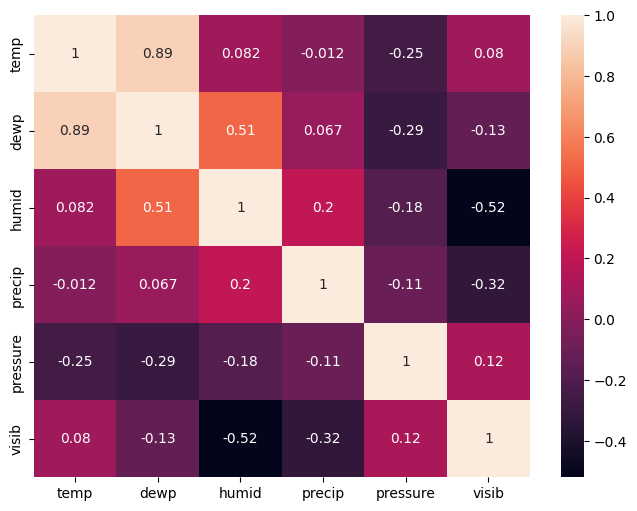

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

weather_corerlation = weather.select('temp', 'dewp', 'humid', 'precip', 'pressure', 'visib')
weather_corerlation_c = weather_corerlation.withColumn('temp', weather_corerlation.temp.cast(FloatType()))\
                      .withColumn('dewp', weather_corerlation.dewp.cast(FloatType()))\
                      .withColumn('humid', weather_corerlation.humid.cast(FloatType()))\
                      .withColumn('pressure', weather_corerlation.pressure.cast(FloatType()))
weather_corerlation_df = weather_corerlation_c.toPandas()

weather_corerlation_df
corr_df = weather_corerlation_df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

# 2. Mission : Créer la DB

In [ ]:
# Les données ont été intégrées à partir de DATABRICKS

# 3. Mission : Créer une WebApp

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=01c6e8fd-08cf-4eba-8815-c5fbca26b5d5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>